<a href="https://colab.research.google.com/github/RoseJaisil/Segmentation-Algorithms/blob/main/3D_Unet_Sand_stone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install libraries

In [10]:
!pip install classification-models-3D
!pip install efficientnet-3D
!pip install segmentation-models-3D
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import libraries

In [11]:
import tensorflow as tf
import keras
import segmentation_models_3D as sm
from skimage import io
from patchify import patchify,unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Checking the GPU

In [12]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device is not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Data Import and unpacking

In [13]:
!unzip /content/drive/MyDrive/sandstone_data_for_ML.zip -d sandstone_data_for_ML

Archive:  /content/drive/MyDrive/sandstone_data_for_ML.zip
   creating: sandstone_data_for_ML/sandstone_data_for_ML/
   creating: sandstone_data_for_ML/sandstone_data_for_ML/data_for_3D_Unet/
  inflating: sandstone_data_for_ML/sandstone_data_for_ML/data_for_3D_Unet/448_images_512x512.tif  
  inflating: sandstone_data_for_ML/sandstone_data_for_ML/data_for_3D_Unet/train_images_256_256_256.tif  
  inflating: sandstone_data_for_ML/sandstone_data_for_ML/data_for_3D_Unet/train_masks_256_256_256.tif  
   creating: sandstone_data_for_ML/sandstone_data_for_ML/full_labels_for_deep_learning/
   creating: sandstone_data_for_ML/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/
  inflating: sandstone_data_for_ML/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/images_as_128x128_patches.tif  
  inflating: sandstone_data_for_ML/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/masks_as_128x128_patches.tif  
  inflating: sandstone_data_for_ML/sandstone_data_f

Loading the images and preparing the dataset

In [28]:
im_path = '/content/sandstone_data_for_ML/sandstone_data_for_ML/data_for_3D_Unet/train_images_256_256_256.tif'
mask_path = '/content/sandstone_data_for_ML/sandstone_data_for_ML/data_for_3D_Unet/train_masks_256_256_256.tif'

image = io.imread(im_path)
image_patches = patchify(image, (64,64,64), step=64)

mask = io.imread(mask_path)
mask_patches = patchify(mask, (64,64,64), step=64)

input_image = np.reshape(image_patches, (-1, image_patches.shape[3], image_patches.shape[4], image_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

n_classes = 4

# stack image to become 3 channel image. This is done to fit in the Unet model
train_image = np.stack((input_image,)*3, axis=-1)
train_mask = np.expand_dims(input_mask, axis=4)
train_mask_cat = to_categorical(train_mask, num_classes=n_classes)

X_train, X_test, y_train, y_test = train_test_split(train_image, train_mask_cat, test_size = 0.1, random_state=0) # for large images test_size =0.2 0r 0.3

Preparing and building the model

In [33]:
encoder_weights = 'imagenet'
BACKBONE = 'vgg16'
activation = 'softmax'
patch_size = 64
n_classes = 4
channels = 3
LR = 0.0001
optimizer = keras.optimizers.Adam(learning_rate=LR)

dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25,0.25,0.25,0.25]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [34]:
preprocess_input = sm.get_preprocessing(BACKBONE) # this step is very crucial

X_train_prep = preprocess_input(X_train)
X_test_prep = preprocess_input(X_test)


Model

In [36]:
model = sm.Unet(BACKBONE, classes=n_classes,
                input_shape=(patch_size, patch_size, patch_size, channels),
                encoder_weights=encoder_weights,
                activation=activation)

model.compile(optimizer=optimizer, loss=total_loss, metrics=metrics)
print(model.summary())

176606448/176606448 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv3D)          (None, 64, 64, 64,   5248        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv3D)          (None, 64, 64, 64,   110656      ['block1_conv1[0][0]']           
                           

Training

In [38]:
history = model.fit(X_train_prep,
                    y_train,
                    batch_size=8,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test_prep, y_test))

Epoch 1/100
8/8 [==============================] - 64s 4s/step - loss: 1.0431 - iou_score: 0.0840 - f1-score: 0.1472 - val_loss: 1.0924 - val_iou_score: 0.1082 - val_f1-score: 0.1747
Epoch 2/100
8/8 [==============================] - 12s 2s/step - loss: 0.9988 - iou_score: 0.2075 - f1-score: 0.3040 - val_loss: 1.1130 - val_iou_score: 0.1205 - val_f1-score: 0.1722
Epoch 3/100
8/8 [==============================] - 12s 2s/step - loss: 0.9755 - iou_score: 0.2642 - f1-score: 0.3709 - val_loss: 1.0951 - val_iou_score: 0.1401 - val_f1-score: 0.1879
Epoch 4/100
8/8 [==============================] - 12s 2s/step - loss: 0.9582 - iou_score: 0.3241 - f1-score: 0.4434 - val_loss: 1.0525 - val_iou_score: 0.1402 - val_f1-score: 0.1921
Epoch 5/100
8/8 [==============================] - 13s 2s/step - loss: 0.9471 - iou_score: 0.3851 - f1-score: 0.5221 - val_loss: 1.0113 - val_iou_score: 0.1624 - val_f1-score: 0.2210
Epoch 6/100
8/8 [==============================] - 13s 2s/step - loss: 0.9382 - iou_s

Always save the model

In [39]:
model.save('/content/drive/MyDrive/3d_unet_sandstone.h5') # save it to the drive

Visualize the performance

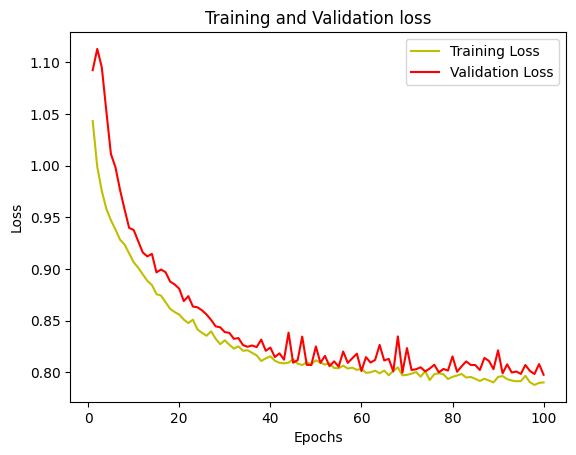

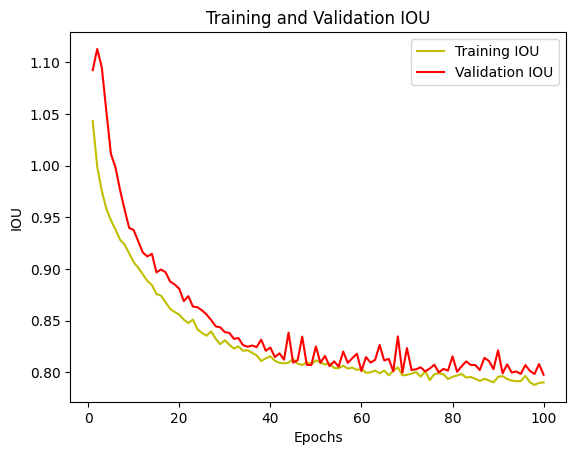

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

iou = history.history['iou_score']
val_iou = history.history['val_iou_score']
plt.plot(epochs, loss, 'y', label='Training IOU')
plt.plot(epochs, val_loss, 'r', label='Validation IOU')
plt.title('Training and Validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

Predictions

In [46]:
# Load the model
from keras.models import load_model
# my_model = load_model('/content/drive/MyDrive/3d_unet_sandstone.h5')

# Prediction
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=4)
y_true_argmax = np.argmax(y_test, axis=4)

1/1 [==============================] - 1s 1s/step


Testing

In [47]:
import random
im_number = random.randint(0, len(X_test))
test_img = X_test[im_number]
ground_truth = y_test[im_number]

test_img_prep = np.expand_dims(test_img, 0)
test_img_prep = preprocess_input(test_img_prep)
test_prediction = model.predict(test_img_prep)
test_prediction_argmax = np.argmax(test_prediction, axis=4)[0,:,:,:]

ground_truth_argmax = np.argmax(ground_truth, axis=3)

1/1 [==============================] - 2s 2s/step


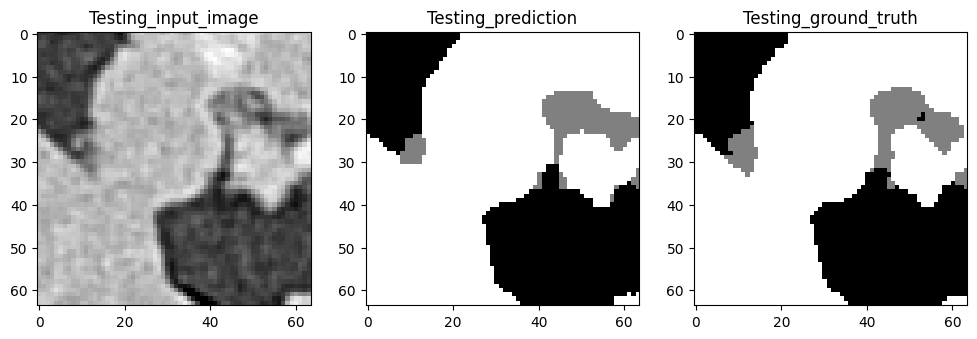

In [56]:
slice = 1
plt.figure(figsize=(12, 8))
plt.subplot(1,3,1)
plt.title('Testing_input_image')
plt.imshow(test_img[slice,:,:,0], cmap='gray')
plt.subplot(1,3,2)
plt.title('Testing_prediction')
plt.imshow(test_prediction_argmax[slice,:,:], cmap='gray')
plt.subplot(1,3,3)
plt.title('Testing_ground_truth')
plt.imshow(ground_truth_argmax[slice,:,:], cmap='gray')
plt.show()

Segment a whole image using the trained and tested model

In [58]:
im_path = '/content/sandstone_data_for_ML/sandstone_data_for_ML/data_for_3D_Unet/448_images_512x512.tif'
image_to_segment = io.imread(im_path)
patches = patchify(image_to_segment, (64,64, 64), step=64)

In [ ]:
# Predict each 3D patches
predicted_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      patch = patches[i,j,k,:,:,:]
      patch = np.stack((patch,)*3, axis=-1)
      patch_prep = preprocess_input(np.expand_dims(patch, axis=0))
      patch_pred = model.predict(patch_prep)
      patch_pred_argmax = np.argmax(patch_pred, axis=4)[0,:,:,:]
      predicted_patches.append(patch_pred_argmax)

# list to array
predicted_patches = np.array(predicted_patches)
predicted_patches = np.reshape(predicted_patches, (patches.shape[0],patches.shape[1],patches.shape[2],patches.shape[3],patches.shape[4],patches.shape[5]))
# unpatchify
reconstrucuted_image = unpatchify(predicted_patches, image_to_segment.shape)

In [62]:
reconstruted_image = reconstrucuted_image.astype(np.uint8)

Save the resultant image

In [63]:
from tifffile import imsave
imsave('/content/drive/MyDrive/3d_unet_sandstone.tif', reconstrucuted_image)

<ipython-input-63-5108392f144b>:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('/content/drive/MyDrive/3d_unet_sandstone.tif', reconstrucuted_image)


#Author: Dr. Sreenivas Bhattiprolu